Code taken from: https://github.com/pytorch/examples/tree/master/vae

In [1516]:
from __future__ import print_function
import argparse
import numpy as np
import os
import h5py
import random
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [1517]:
# modify to accept hard coded arguments
batch_size = 8
epochs = 20
no_cuda = False
log_interval = 1

cuda = not no_cuda and torch.cuda.is_available()
# cuda = False

seed = 1
torch.manual_seed(seed)


# device = torch.device("cuda" if args.cuda else "cpu")
device = torch.device("cuda" if cuda else "cpu")

# kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [ ]:
def define_test(s_test, s_train):
    #2048/16=128
    m=8
    x=random.randint(0,m)*s_train
    y=random.randint(0,m)*s_train
    z=random.randint(0,m)*s_train
    #print(x,y,z)
    return {'x':[x,x+s_test], 'y':[y,y+s_test], 'z':[z,z+s_test]}

def check_coords(test_coords, train_coords):
    valid=True
    for i in ['x','y','z']:
        r=(max(test_coords[i][0], 
               train_coords[i][0]), 
           min(test_coords[i][1],
               train_coords[i][1]))
        if r[0]<=r[1]:
            valid=False
    return valid

In [ ]:
# # getting the max of the whole cube
# f = h5py.File('fields_z=1.0.hdf5', 'r')
# f=f['delta_HI']
# #print(f.shape)
# max_list = []
# for i in range(f.shape[0]):
#     #print(np.max(f[i:i+1,:,:]))
#     max_list.append(np.max(f[i:i+1,:,:]))
# max(max_list)

In [ ]:
def get_samples(s_sample, nsamples, redshift, test_coords):
    #n is size of minibatch, get valid samples (not intersecting with test_coords)
    sample_list=[]
    m=2048-128
    for n in range(nsamples):
        #print("Sample No = " + str(n + 1) + " / " + str(nsamples))
        sample_valid=False
        while sample_valid==False:
            x = random.randint(0,m)
            y = random.randint(0,m)
            z = random.randint(0,m)
            sample_coords = {'x':[x,x+s_sample], 
                             'y':[y,y+s_sample], 
                             'z':[z,z+s_sample]}
            
            sample_valid = check_coords(test_coords, 
                                        sample_coords)
        
        sample_list.append(sample_coords)
    
    print("Sampling finished.")
        
    #Load cube and get samples and convert them to np.arrays
    sample_array=[]
    datapath=''
    f = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
    f=f['delta_HI']
    
    # getting the max of the whole cube
    #print(f.shape)
    max_list = []
    for i in range(f.shape[0]):
        #print(np.max(f[i:i+1,:,:]))
        max_list.append(np.max(f[i:i+1,:,:]))
    max_cube = max(max_list)
    #f.close()
    
    print("Getting max value finished.")
    
    counter = 0
    for c in sample_list:
        print("Counter = " + str(counter + 1) + " / " + str(len(sample_list)))
        a = f[c['x'][0]:c['x'][1],
              c['y'][0]:c['y'][1],
              c['z'][0]:c['z'][1]]
        
        # a = np.array(a)
        a = np.array(a) / max_cube
        sample_array.append(a)
    
        counter = counter + 1
        
    f=0
    return sample_array

In [ ]:
t_coords=define_test(1024,128)

In [ ]:
a=get_samples(128,1,'1.0',t_coords)
len(a)

In [ ]:
# %%timeit
# a=get_samples(128,1,'1.0',t_coords)
# len(a)

In [ ]:
class HydrogenDataset2(Dataset):
    """Hydrogen Dataset"""

    def __init__(self, h5_file, root_dir, s_test, s_train,
                 s_sample, nsamples, redshift):
        """
        Args:
            h5_file (string): name of the h5 file with 32 sampled cubes.
            root_dir (string): Directory with the .h5 file.
        """
        file_size = os.path.getsize(root_dir + h5_file) / 1e6 # in MBs
        print("The whole file size is " + str(int(file_size)) + " MBs")
        
        # self.subcubes = h5py.File('../data/sample_32.h5', 'r')
        self.subcubes = h5py.File(root_dir + h5_file, 'r')["delta_HI"]
        self.h5_file = h5_file
        self.root_dir = root_dir
        self.s_test = s_test
        self.s_train = s_train
        self.t_coords = define_test(self.s_test,
                                    self.s_train)
        self.s_sample = s_sample
        self.nsamples = nsamples
        self.redshift = redshift
        
        self.samples = get_samples(s_sample = self.s_sample,
                             nsamples = self.nsamples,
                             redshift = self.redshift,
                             test_coords = self.t_coords)

    def __len__(self):
        # Function called when len(self) is executed
        
        #print(len(self.subcubes))
#         return len(self.nsamples)
        return self.nsamples

    def __getitem__(self, idx):
        """
        This can be implemented in such a way that the whole h5 file read 
        using h5py.File() and get_sample() function is called to return
        a random subcube. This won't increase memory usage because the
        subcubes will be read in the same way and only the batch will
        be read into memory.
        
        Here we have implemented it so that it can be used with data
        generated by get_sample() function.
        
        The output of this function is one subcube with the dimensions
        specified by get_sample() implementation.
        """
        
        # default version -> error in training because of dimensions
#         sample = self.subcubes[idx]
        
        # reshaped version to add another dimension
#         sample = self.subcubes[idx].reshape((1,128,128,128))

        # On prince using get_samples()
#         print("nsamples = " + str(self.nsamples))
#         sample = get_samples(s_sample = self.s_sample,
#                              nsamples = self.nsamples,
#                              redshift = self.redshift,
#                              test_coords = self.t_coords)
    
        sample = self.samples[idx].reshape((1,128,128,128))
        
        # added division by 1e6 for exploding variance
        # and resulting in inf during reparametrization trick part
        sample = sample/1e6

        return sample

In [1280]:
class HydrogenDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, h5_file, root_dir):
        """
        Args:
            h5_file (string): name of the h5 file with 32 sampled cubes.
            root_dir (string): Directory with the .h5 file.
        """
        file_size = os.path.getsize(root_dir + h5_file) / 1e6 # in MBs
        print("The file size is " + str(int(file_size)) + " MBs")
        
        # self.subcubes = h5py.File('../data/sample_32.h5', 'r')
        self.subcubes = h5py.File(root_dir + h5_file, 'r')['sample32']
        self.h5_file = h5_file
        self.root_dir = root_dir

    def __len__(self):
        # Function called when len(self) is executed
        
        #print(len(self.subcubes))
        return len(self.subcubes)

    def __getitem__(self, idx):
        """
        This can be implemented in such a way that the whole h5 file read 
        using h5py.File() and get_sample() function is called to return
        a random subcube. This won't increase memory usage because the
        subcubes will be read in the same way and only the batch will
        be read into memory.
        
        Here we have implemented it so that it can be used with data
        generated by get_sample() function.
        
        The output of this function is one subcube with the dimensions
        specified by get_sample() implementation.
        """
        
        # default version -> error in training because of dimensions
        #sample = self.subcubes[idx]
        
        # reshaped version to add another dimension
        sample = self.subcubes[idx].reshape((1,128,128,128))

        return sample

In [ ]:
sampled_subcubes = HydrogenDataset2(h5_file="fields_z=1.0.hdf5",
                                    root_dir = "",
                                    s_test = 1024, 
                                    s_train = 128,
                                    s_sample = 128, 
                                    nsamples = 256, 
                                    redshift = "1.0")
# print(type(sampled_subcubes))
# print(len(sampled_subcubes))
# print(len(sampled_subcubes[0]))
#print(len(sampled_subcubes[1]))
# print(len(sampled_subcubes[0][0]))
# print(len(sampled_subcubes[0][0][0]))
#print(len(sampled_subcubes[1][0]))
#sampled_subcubes

In [1515]:
sampled_subcubes = HydrogenDataset(h5_file="sample_32.h5",
                                    root_dir = "../data/")
print(len(sampled_subcubes))
sampled_subcubes

The file size is 268 MBs
32


In [1282]:
# Data Loaders
train_loader = DataLoader(
        dataset=sampled_subcubes,
        #batch_size=args.batch_size, 
        batch_size=batch_size,
        shuffle=True, 
        **kwargs)

test_loader = DataLoader(
        dataset=sampled_subcubes,
        #batch_size=args.batch_size, 
        batch_size=batch_size,
        shuffle=True, 
        **kwargs)

In [1502]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        """
        The Encoding Layers
        nn.Conv3d 
        nn.MaxPool3d 
        
        out_channels is the number of different filters we convolute 
        over the whole sampled subcube.
        
        So the first convolutional layer's in_channel should be 0 (?)
        
        In addition, the next layer's in_channel should be equal to
        the previous layer's out_channels (all examples show that
        this is the case)
        """
        
        # Convolutional Layer 1
        self.encode_conv1 = nn.Conv3d(in_channels=1, 
                                      out_channels=8, 
                                      kernel_size=(4,4,4), # == 4
                                      stride = (2,2,2), # == 2
                                      padding=(1,1,1)) # == 1
        nn.init.xavier_uniform_(self.encode_conv1.weight) #Xaviers Initialisation
        
        self.encode_relu1 = nn.ReLU()
        self.encode_maxpool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), 
                                             stride=(2, 2, 2),
                                            return_indices = True)
        
        # Convolutional Layer 2
        self.encode_conv2 = nn.Conv3d(in_channels=8, 
                                      out_channels=16, 
                                      kernel_size=(4,4,4), # == 4 
                                      stride = (2,2,2),
                                      padding=(1,1,1))
        nn.init.xavier_uniform_(self.encode_conv2.weight) #Xaviers Initialisation
        
        self.encode_relu2 = nn.ReLU()
        self.encode_maxpool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), 
                                             stride=(2, 2, 2),
                                            return_indices = True)

        # Convolutional Layer 3
        self.encode_conv3 = nn.Conv3d(in_channels=16, 
                                      out_channels=32, 
                                      kernel_size=(4,4,4), # == 4 
                                      stride = (2,2,2),
                                      padding=(1,1,1))
        nn.init.xavier_uniform_(self.encode_conv3.weight) #Xaviers Initialisation
        
        self.encode_relu3 = nn.ReLU()
#         self.encode_maxpool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), 
#                                              stride=(2, 2, 2),
#                                             return_indices = True)

        
        
        """
        Fully Connected Layers after 3D Convolutional Layers
        First FC layer's input should be equal to 
        last convolutional layer's output
        8192 = 8^3 * 16 
            8^3 = (output of 2nd convolutional layer)
            16 = number of out_channels
        """
        
#         self.encode_fc1 = nn.Sequential(
#             nn.Linear(in_features=2048, 
#                       out_features=5096), 
#             nn.ReLU(),
#             nn.Dropout(0.5))
        
        self.encode_fc1_linear = nn.Linear(in_features=2048, 
                                           out_features=128)
        self.encode_fc1_relu = nn.ReLU()
        self.encode_fc1_dropout = nn.Dropout(0.5)
        nn.init.xavier_uniform_(self.encode_fc1_linear.weight) #Xaviers Initialisation

        
#         self.encode_fc2 = nn.Sequential(
#             nn.Linear(in_features = 5096,
#                       out_features = 5096),
#             nn.ReLU(),
#             nn.Dropout(0.5))

        self.encode_fc2_linear = nn.Linear(in_features=128, 
                                           out_features=128)
        self.encode_fc2_relu = nn.ReLU()
        self.encode_fc2_dropout = nn.Dropout(0.5)
        nn.init.xavier_uniform_(self.encode_fc2_linear.weight) #Xaviers Initialisation
        
        """
        The last fully connected layer's output is the dimensions
        of the embeddings?
        
        PyTorch VAE example uses output of 20 dimensions for mu &
        logvariance
        """
#         self.encode_fc31 = nn.Sequential(
#             nn.Linear(in_features=5096,
#                       out_features=20))
        
        self.encode_fc31_linear = nn.Linear(in_features=128, 
                                           out_features=10)
        self.encode_fc31_relu = nn.ReLU()
        self.encode_fc31_dropout = nn.Dropout(0.5)
        nn.init.xavier_uniform_(self.encode_fc31_linear.weight) #Xaviers Initialisation

        
#         self.encode_fc32 = nn.Sequential(
#             nn.Linear(in_features=5096,
#                       out_features=20))

        self.encode_fc32_linear = nn.Linear(in_features=128, 
                                           out_features=10)
        self.encode_fc32_relu = nn.ReLU()
        self.encode_fc32_dropout = nn.Dropout(0.5)
        nn.init.xavier_uniform_(self.encode_fc32_linear.weight) #Xaviers Initialisation

        
        
        """
        The Decoding Layers
        nn.Conv3d -> nn.ConvTranspose3d
        nn.MaxPool3d -> nn.MaxUnpool3d
        """
        
        self.decode_fc1 = nn.Sequential(
            nn.Linear(in_features=10,
                      out_features=128))
        
        self.decode_fc2 = nn.Sequential(
            nn.Linear(in_features=128, 
                      out_features=128), 
            nn.ReLU(),
            nn.Dropout(0.5))
        #init.xavier_normal(self.fc1.state_dict()['weight'])
        
        self.decode_fc3 = nn.Sequential(
            nn.Linear(in_features = 128,
                      out_features = 2048),
            nn.ReLU(),
            nn.Dropout(0.5))
        #init.xavier_normal(self.fc2.state_dict()['weight'])
        
        
        self.decode_conv1 = nn.ConvTranspose3d(in_channels=32, 
                                              out_channels=16, 
                                              kernel_size=(4,4,4),
                                              stride = (2,2,2),
                                              padding=(1,1,1))
        self.decode_relu1 = nn.ReLU()
        self.decode_maxunpool1 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), 
                                                     stride=(2, 2, 2))
        #init.xavier_normal(self.group1.state_dict()['weight'])
        
        self.decode_conv2 = nn.ConvTranspose3d(in_channels=16, 
                                              out_channels=8, 
                                              kernel_size=(4,4,4),
                                              stride = (2,2,2),
                                              padding=(1,1,1))
        self.decode_relu2 = nn.ReLU()
        self.decode_maxunpool2 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), 
                                                     stride=(2, 2, 2))
        
        self.decode_conv3 = nn.ConvTranspose3d(in_channels=8, 
                                              out_channels=1, 
                                              kernel_size=(4,4,4),
                                              stride = (2,2,2),
                                              padding=(1,1,1))
        self.decode_relu3 = nn.ReLU()
        self.decode_maxunpool3 = nn.MaxUnpool3d(kernel_size=(2, 2, 2), 
                                                     stride=(2, 2, 2))
        
        
    # Encoding part of VAE
    def encode(self, x):
#         h1 = F.relu(self.fc1(x))
#         return self.fc21(h1), self.fc22(h1)

        print("Starting Encoding")
#         print("----------------------------")
        
        out = self.encode_conv1(x)
#         print("First Conv output shape = " + str(out.shape))
        #print(out.shape)
        out = self.encode_relu1(out)
#         print("First ReLU Layer output shape = " + str(out.shape))
        size1 = out.size()
        out, ind1 = self.encode_maxpool1(out)
#         print("First MaxPooling output shape = " + str(out.shape))
#         print("Ind1 shape = " + str(ind1.shape))
#         #print("Size1 = " + str(size1))
#         print("----------------------------")
        
        out = self.encode_conv2(out)
#         print("Second Conv output shape = " + str(out.shape))
        out = self.encode_relu2(out)
#         print("Second ReLU Layer output shape = " + str(out.shape))
        size2 = out.size()
        out, ind2 = self.encode_maxpool2(out)
#         print("Second MaxPooling output shape = " + str(out.shape))
#         print("Ind2 shape = " + str(ind2.shape))
        #print("Size2 = " + str(size2))
#          print("----------------------------")
        
        out = self.encode_conv3(out)
#         print("Last Conv output shape = " + str(out.shape))
        out = self.encode_relu3(out)
#         print("Last ReLU output shape = " + str(out.shape))
        size3 = out.size()
#         out, ind3 = self.encode_maxpool3(out)
#         print("Last Conv Layer output shape = " + str(out.shape))
#         print("Ind3 shape = " + str(ind3.shape))
        #print("Size3 = " + str(size3))
#         print("----------------------------")

        """
        From here on, the convolutional layers' output is flattened
        into a rank 1 tensor of size x & put into a fully connected 
        network to output ??????
        
        https://github.com/pytorch/examples/blob/master/vae/main.py
        PyTorch's own example uses just 2 fully-connected layers
        to output mu and logvar predictions, below we use 3.
        """
        #out = out.view(out.size(0), -1)
        
        
        # batch_size = 1 - WORKS
#         out = out.view(1, -1)
        # batch_size != 1
        out = out.view(batch_size, -1)
        print(out.shape)
        
#         print("Last Conv Layer output shape after reshaping \n \
#                 (Input to first FC layer) = " + str(out.shape))
        
#         out = self.encode_fc1(out)
    
        out = self.encode_fc1_linear(out)
        out = self.encode_fc1_relu(out)
        out = self.encode_fc1_dropout(out)
        
#         out = self.encode_fc2(out)

        out = self.encode_fc2_linear(out)
        out = self.encode_fc2_relu(out)
        out = self.encode_fc2_dropout(out)
        
        
#         out_mu = self.encode_fc31(out)
        
        out_mu = self.encode_fc31_linear(out)
        out_mu = self.encode_fc31_relu(out_mu)
        out_mu = self.encode_fc31_dropout(out_mu)
        
#         out_logvar = self.encode_fc32(out)

        out_logvar = self.encode_fc32_linear(out)
        out_logvar = self.encode_fc32_relu(out_logvar)
        out_logvar = self.encode_fc32_dropout(out_logvar)
        
        print("Encode - Forward Pass Finished")
        print(out_mu.shape)
        print(out_logvar.shape)
#         print("----------------------------")
        
#         return out_mu, out_logvar, [ind1,ind2,ind3], [size1,size2,size3]
        return out_mu, out_logvar, [ind1,ind2], [size1,size2]
    

    # Reparametrization Trick
    def reparameterize(self, mu, logvar):
        """
        torch.exp = returns a new tensor with the exponential of 
                    the elements of input
        rand_like = returns a tensor with the same size as input
                    that is filled with random numbers from a normal
                    distribution with mean 0 and variance 1
        
        """
#         print("Reparametrization...")
#         print("logvar (in reparametrization) = \n" + str(logvar))
#         print("logvar (in reparametrization) = \n" + str(logvar*1e6))
#         print("mu * 1e6 (in reparametrization) = \n" + str(mu))
#         print("mu * 1e6 (in reparametrization) = \n" + str(mu*1e6))
        
        std = torch.exp(0.5*logvar)
#         std = logvar.mul(0.5).exp_()
        eps = torch.randn_like(std)
        
#         print("0.5*logvar (in reparametrization) = \n" + str(0.5*logvar))
#         print("std (in reparametrization) = \n" + str(std))
#         print("eps (in reparametrization) = \n" + str(eps))
         
#         print("eps.mul(std).add_(mu) \n \
#                 [This is the output from reparameterize()] =\
#                     \n" + str(eps.mul(std).add_(mu)))
        
        return eps.mul(std).add_(mu)
    
    
    # Decoding part of VAE
    def decode(self, z, indices_list, size_list):
#         h3 = F.relu(self.fc3(z))
#         return torch.sigmoid(self.fc4(h3))
#         print("----------------------------")
        print("Starting Decoding")
#         print("z shape = " + str(z.shape))
        
        out = self.decode_fc1(z)
#         print("1st FC output shape = " + str(out.shape))
        out = self.decode_fc2(out)
#         print("2nd FC output shape = " + str(out.shape))
        out = self.decode_fc3(out)
#         print("Last FC output shape = " + str(out.shape))
        
        # batch_size = 1 - WORKS
#         out = out.view(1, 32, 4, 4, 4)
        # batch_size != 1 
        out = out.view(batch_size, 32, 4, 4, 4)        
        
        
#         print("First Deconv input shape = " + str(out.shape))
#         print("After last convolution (encoding stage) output shape = " +\
#                   str(indices_list[1].shape))
        out = self.decode_conv1(out)
#         print("First Deconv output shape = " + str(out.shape))
        out = self.decode_relu1(out)
#         print("First ReLU output shape = " + str(out.shape))
        # maxunpooling needs indices

#         out = self.decode_maxunpool1(out,
#                              indices = indices_list[1])
        out = self.decode_maxunpool1(out,
                                     indices = indices_list[1],
                                     output_size = size_list[1])
#         print("2nd MaxUnpool ouput shape = " + str(out.shape))
        
        out = self.decode_conv2(out)
#         print("2nd Deconv output shape = " + str(out.shape))
        out = self.decode_relu2(out)
#         print("2nd ReLU output shape = " + str(out.shape))
        out = self.decode_maxunpool1(out,
                     indices = indices_list[0])
#         out = self.decode_maxunpool2(out,
#                                      indices= indices_list[1],
#                                      output_size = size_list[1])
        
        out = self.decode_conv3(out)
        out = self.decode_relu3(out)
#         print("Last ReLU output shape = " + str(out.shape))
#         out = self.decode_maxunpool1(out,
#                              indices = indices_list[0])
        # there is no last maxunpool in https://github.com/pgtgrly/Convolution-Deconvolution-Network-Pytorch/blob/master/Neural_Network_Class.py
#         out = self.decode_maxunpool2(out,
#                                      indices= indices_list[0],
#                                      output_size = size_list[0])
        
        return out
    

    # Forward Pass
    def forward(self, x):
#         mu, logvar = self.encode(x.view(-1, 784))
        mu, logvar, indices_list, size_list = self.encode(x)
#         print("logvar (after encoding) = \n" + str(logvar))
#         print("mu (after encoding) = \n" + str(mu))
        
        z = self.reparameterize(mu, logvar)
#         print("z = ")
#         print(z)
        reconstructed_x = self.decode(z, indices_list, size_list)
    
        return reconstructed_x , mu, logvar
       

In [1503]:
model = VAE().to(device)

In [1504]:
# for param in model.parameters():
#     print(param.name)
#     print(type(param.data), param.size())

In [1505]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [1506]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
#     print("--------------------------------------")
#     print("Calculating Loss...")
#     print("recon_x shape = " + str(recon_x.shape))
    
#     BCE = F.binary_cross_entropy(recon_x, 
#                                  x.view(-1, 1, 128, 128, 128), 
#                                  reduction='sum')
#     print("BCE Loss = " + str(BCE))


    """
    https://towardsdatascience.com/teaching-a-variational-autoencoder-vae-to-draw-mnist-characters-978675c95776
    This article is about reconstructing MNIST dataset (2D images with 1 channels)
    And it uses squared difference for the reconstruction loss, thus
    it is safe to say that for 3D reconstruction we might use the same thing too.
    
    But the MSE loss seems to be around 1e20 magnitude, thus suggesting some
    bug might exist in it.
    """
    MSE = F.mse_loss(recon_x, 
                     x.view(-1, 1, 128, 128, 128), 
                     reduction='sum') # / 1e18
    
    print("MSE Loss = " + str(MSE))

    """
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    # https://vxlabs.com/2017/12/08/variational-autoencoder-in-pytorch-commented-and-annotated/
    # normalises the KLD loss by batch_size
    """
#     print("logvar (KLD Loss) = \n" + str(logvar))
#     print("mu (KLD Loss) = \n" + str(mu))
#     print("logvar.exp() (KLD Loss) = \n" + str(logvar.exp()))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD = KLD / float(batch_size)
    print("KLD Loss = " + str(KLD))

    
#     return MSE
#     return BCE
#     return BCE + KLD
    return MSE + KLD

In [1507]:
#list(enumerate(train_loader))[0]

In [1508]:
#list(enumerate(train_loader))[0][0]

In [1509]:
#list(enumerate(train_loader))[0][1]

In [1510]:
#list(enumerate(train_loader))[0][2]

In [1511]:
list(enumerate(train_loader))[0][1].shape

torch.Size([1, 1, 128, 128, 128])

In [1512]:
def train(epoch):
    model.train()
    train_loss = 0
#     for batch_idx, (data, _) in enumerate(train_loader):
    for batch_idx, data in enumerate(train_loader):
#         print(batch_idx)
#         print(data)
        
        #print("Batch size = " + str(data.shape))
        
        data = data.to(device)
        print("Data transfer to device completed.")
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        
#         print("Reconstructed Input = \n " + str(recon_batch))
#         print("Real Input = \n " + str(data))
#         print("Reconstructed Input Shape = \n " + str(recon_batch.shape))
#         print("Real Input Shape = \n " + str(data.shape))

#         print("logvar = \n" + str(logvar))
#         print("mu = \n" + str(mu))
        
        loss = loss_function(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        
        loss_history.append(loss.item())
        
        optimizer.step()
        # if batch_idx % args.log_interval == 0:
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.12f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.12f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [1513]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
#         for i, (data, _) in enumerate(test_loader):
        for i, data in enumerate(test_loader):
            data = data.to(device)
            
            
            
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], 
                                        recon_batch.view(batch_size, 1, 128, 128, 128)[:n]])
                                      #recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
#                                         recon_batch.view(batch_size, 1, 28, 28)[:n]])
#                 save_image(comparison.cpu(),
#                          'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.12f}'.format(test_loss))

Epoch = 1 / 20
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0.0000e+00, 0.0000e+00, 4.5429e+06, 4.0098e+05, 3.9971e+06, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 2.9019e+05, 0.0000e+00, 1.4348e+06,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6227e+06, 5.0755e+06, 0.0000e+00,
         0.0000e+00, 0.0000e+00]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[4.8991e+06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 4.5237e+06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.7581e+06, 0.0000e+00, 0.0000e+00, 1.2391e+06,
         0.0000e+00, 0.0000e+00]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0.0000e+00, 0.0000e+00, 4.5429e+06, 4.0098e+05, 3.9971e+06, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00

Last ReLU output shape = torch.Size([1, 1, 128, 128, 128])
--------------------------------------
Calculating Loss...
MSE Loss = tensor(3682479121067147264., grad_fn=<MseLossBackward>)
KLD Loss = tensor(4.9472e-06, grad_fn=<DivBackward0>)
Train Epoch: 1 [3/32 (9%)]	Loss: 3682479121067147264.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0.,

Last ReLU output shape = torch.Size([1, 1, 128, 128, 128])
--------------------------------------
Calculating Loss...
MSE Loss = tensor(6439071595012030464., grad_fn=<MseLossBackward>)
KLD Loss = tensor(-0., grad_fn=<DivBackward0>)
Train Epoch: 1 [8/32 (25%)]	Loss: 6439071595012030464.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0

Last ReLU output shape = torch.Size([1, 1, 128, 128, 128])
--------------------------------------
Calculating Loss...
MSE Loss = tensor(40561705228284461056., grad_fn=<MseLossBackward>)
KLD Loss = tensor(-0., grad_fn=<DivBackward0>)
Train Epoch: 1 [13/32 (41%)]	Loss: 40561705228284461056.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.

Last ReLU output shape = torch.Size([1, 1, 128, 128, 128])
--------------------------------------
Calculating Loss...
MSE Loss = tensor(1386609781829009408., grad_fn=<MseLossBackward>)
KLD Loss = tensor(-0., grad_fn=<DivBackward0>)
Train Epoch: 1 [18/32 (56%)]	Loss: 1386609781829009408.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 

Last ReLU output shape = torch.Size([1, 1, 128, 128, 128])
--------------------------------------
Calculating Loss...
MSE Loss = tensor(13218407953960271872., grad_fn=<MseLossBackward>)
KLD Loss = tensor(-0., grad_fn=<DivBackward0>)
Train Epoch: 1 [23/32 (72%)]	Loss: 13218407953960271872.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.

Last ReLU output shape = torch.Size([1, 1, 128, 128, 128])
--------------------------------------
Calculating Loss...
MSE Loss = tensor(1425600938051108864., grad_fn=<MseLossBackward>)
KLD Loss = tensor(-0., grad_fn=<DivBackward0>)
Train Epoch: 1 [28/32 (88%)]	Loss: 1425600938051108864.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 

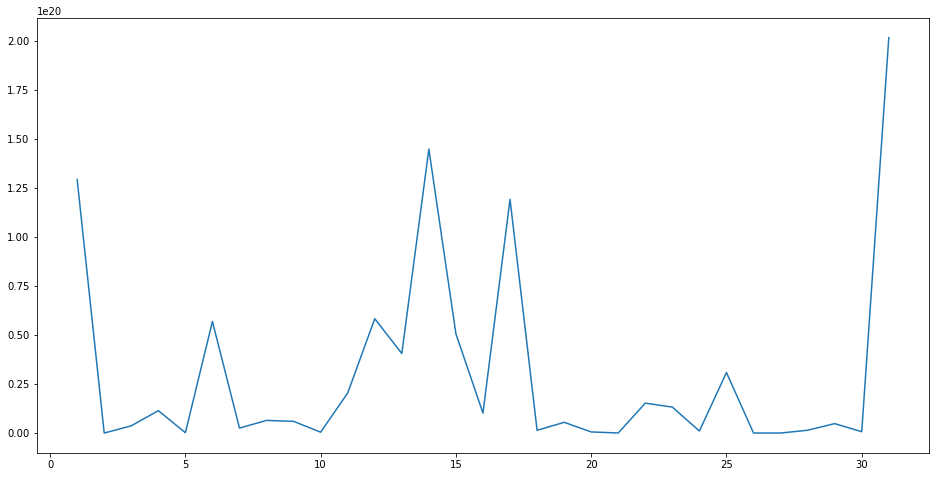

Epoch = 2 / 20
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulBackward>)
std (in reparametrization) = 
tensor(

Train Epoch: 2 [4/32 (12%)]	Loss: 431491278052524032.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulBac

Train Epoch: 2 [9/32 (28%)]	Loss: 13218407953960271872.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulB

Train Epoch: 2 [14/32 (44%)]	Loss: 3682479121067147264.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulB

Train Epoch: 2 [19/32 (59%)]	Loss: 1425600938051108864.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulB

Train Epoch: 2 [24/32 (75%)]	Loss: 119241552247190978560.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<Mu

Train Epoch: 2 [29/32 (91%)]	Loss: 7129966218999496704.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulB

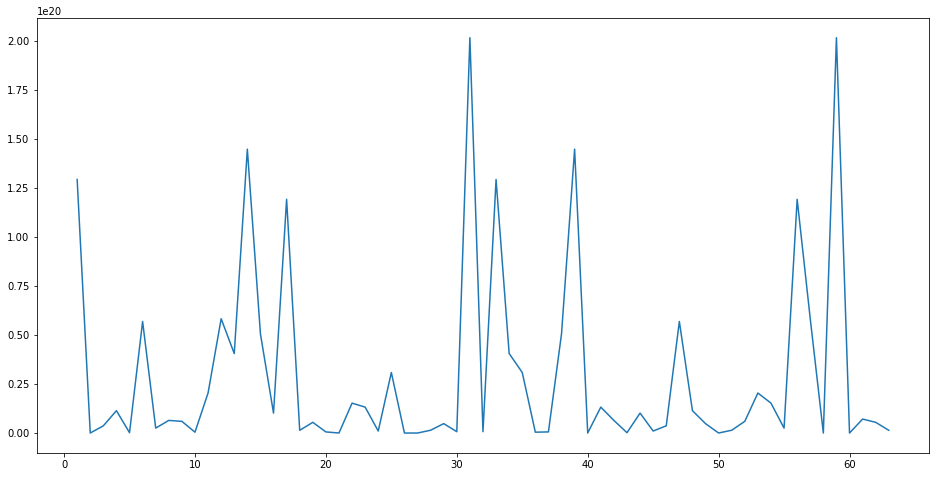

Epoch = 3 / 20
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulBackward>)
std (in reparametrization) = 
tensor(

Train Epoch: 3 [4/32 (12%)]	Loss: 201689698293369536512.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<Mul

Train Epoch: 3 [9/32 (28%)]	Loss: 4799747036998008832.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulBa

Train Epoch: 3 [14/32 (44%)]	Loss: 5458832239838101504.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulB

Train Epoch: 3 [19/32 (59%)]	Loss: 56907392532476854272.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<Mul

Train Epoch: 3 [24/32 (75%)]	Loss: 681490707193528320.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulBa

Train Epoch: 3 [29/32 (91%)]	Loss: 673125930893312.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulBackw

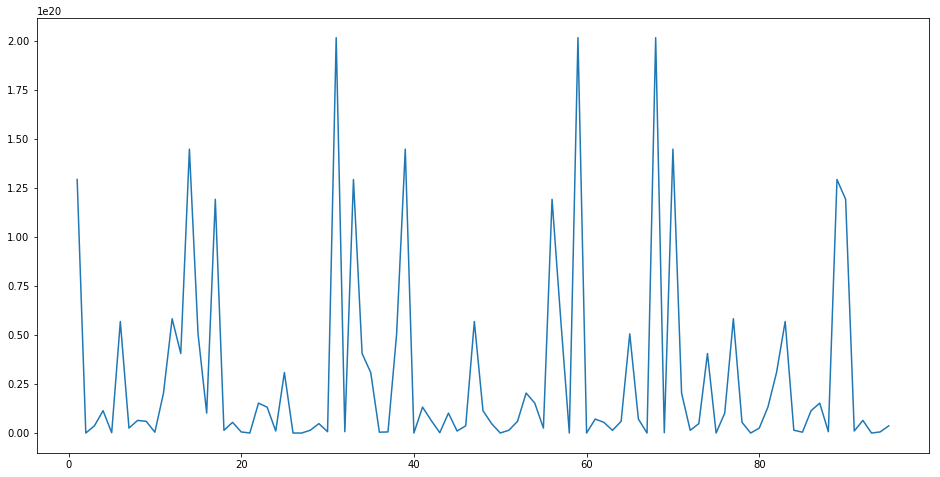

Epoch = 4 / 20
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulBackward>)
std (in reparametrization) = 
tensor(

Train Epoch: 4 [4/32 (12%)]	Loss: 129342009107569180672.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<Mul

Train Epoch: 4 [9/32 (28%)]	Loss: 20418227795939819520.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulB

Train Epoch: 4 [14/32 (44%)]	Loss: 201689698293369536512.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<Mu

Train Epoch: 4 [19/32 (59%)]	Loss: 6439071595012030464.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulB

Train Epoch: 4 [24/32 (75%)]	Loss: 40561705228284461056.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<Mul

Train Epoch: 4 [29/32 (91%)]	Loss: 58316856488122908672.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<Mul

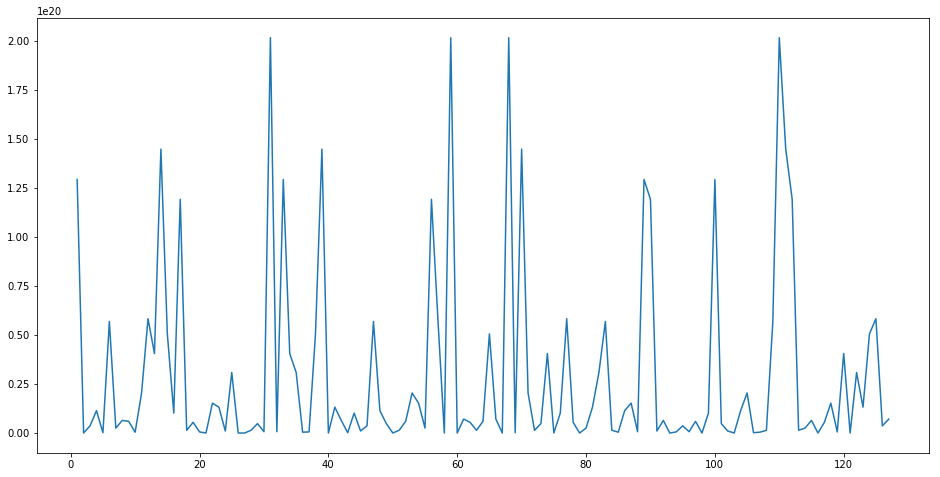

Epoch = 5 / 20
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulBackward>)
std (in reparametrization) = 
tensor(

Train Epoch: 5 [4/32 (12%)]	Loss: 20418227795939819520.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulB

Train Epoch: 5 [9/32 (28%)]	Loss: 58316856488122908672.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulB

Train Epoch: 5 [14/32 (44%)]	Loss: 431491278052524032.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulBa

Train Epoch: 5 [19/32 (59%)]	Loss: 201689698293369536512.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<Mu

Train Epoch: 5 [24/32 (75%)]	Loss: 15249034406648610816.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<Mul

Train Epoch: 5 [29/32 (91%)]	Loss: 2520466579443941376.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulB

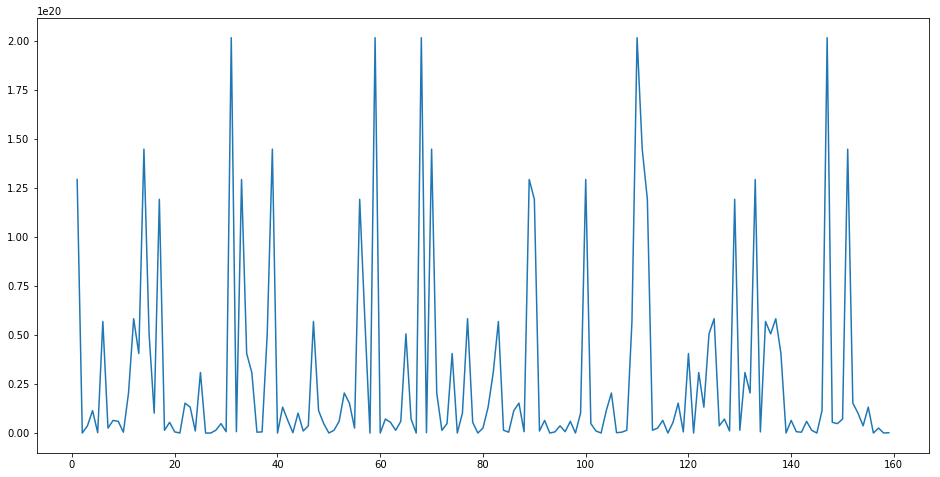

Epoch = 6 / 20
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulBackward>)
std (in reparametrization) = 
tensor(

Train Epoch: 6 [4/32 (12%)]	Loss: 1026129259665555456.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulBa

Train Epoch: 6 [9/32 (28%)]	Loss: 201689698293369536512.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<Mul

Train Epoch: 6 [14/32 (44%)]	Loss: 171314803644563456.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulBa

Train Epoch: 6 [19/32 (59%)]	Loss: 10166051525068062720.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<Mul

Train Epoch: 6 [24/32 (75%)]	Loss: 1024848.250000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulBackward>)
st

Train Epoch: 6 [29/32 (91%)]	Loss: 431491278052524032.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulBa

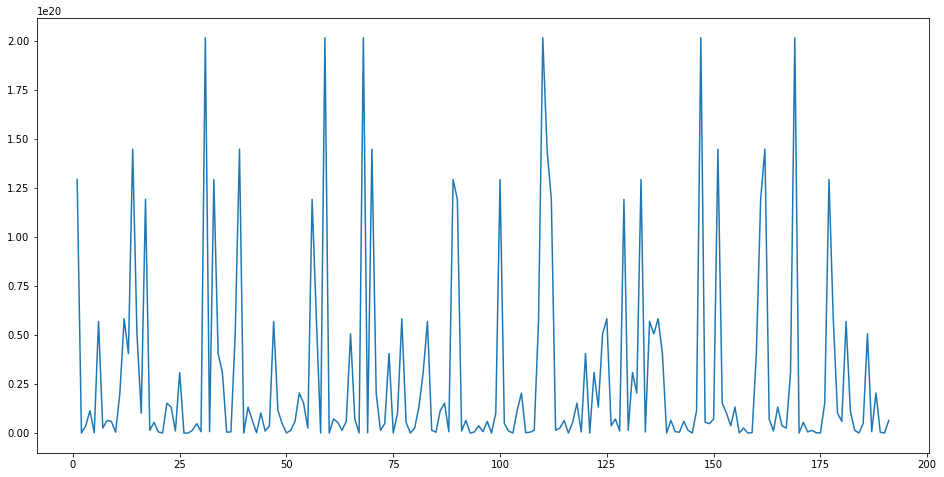

Epoch = 7 / 20
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulBackward>)
std (in reparametrization) = 
tensor(

Train Epoch: 7 [4/32 (12%)]	Loss: 119241552247190978560.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<Mul

Train Epoch: 7 [9/32 (28%)]	Loss: 431491278052524032.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulBac

Train Epoch: 7 [14/32 (44%)]	Loss: 568431053245513728.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulBa

Train Epoch: 7 [19/32 (59%)]	Loss: 30881037509344624640.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<Mul

Train Epoch: 7 [24/32 (75%)]	Loss: 50599472333693386752.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<Mul

Train Epoch: 7 [29/32 (91%)]	Loss: 10166051525068062720.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<Mul

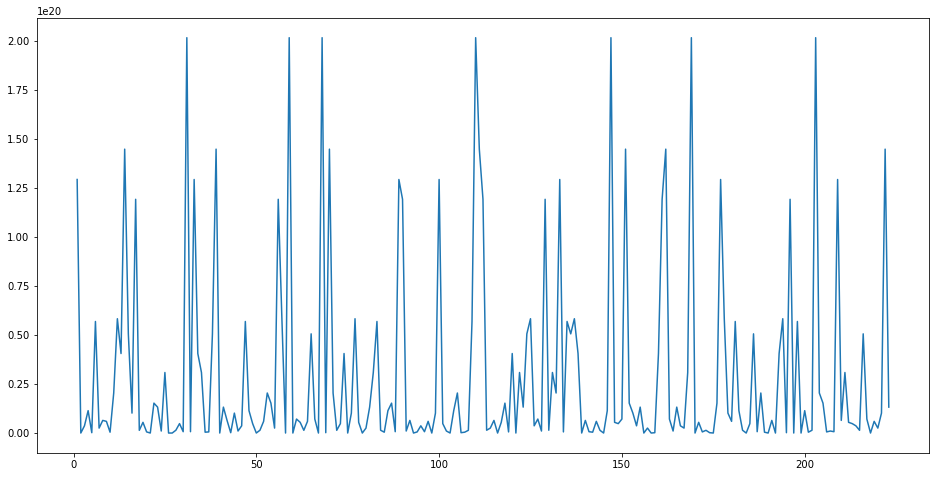

Epoch = 8 / 20
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulBackward>)
std (in reparametrization) = 
tensor(

Train Epoch: 8 [4/32 (12%)]	Loss: 10166051525068062720.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulB

Train Epoch: 8 [9/32 (28%)]	Loss: 673125930893312.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulBackwa

Train Epoch: 8 [14/32 (44%)]	Loss: 3682479121067147264.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulB

Train Epoch: 8 [19/32 (59%)]	Loss: 92985538641920.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulBackwa

Train Epoch: 8 [24/32 (75%)]	Loss: 5458832239838101504.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulB

Train Epoch: 8 [29/32 (91%)]	Loss: 568431053245513728.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulBa

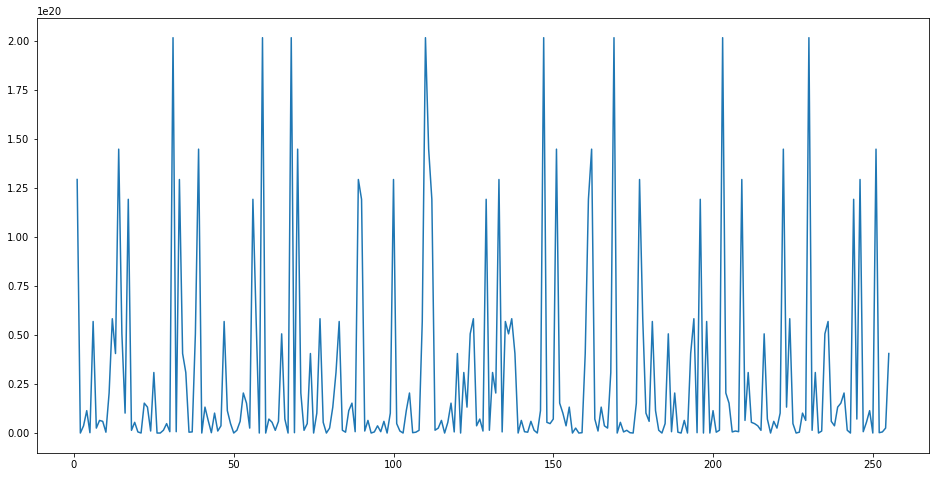

Epoch = 9 / 20
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulBackward>)
std (in reparametrization) = 
tensor(

Train Epoch: 9 [4/32 (12%)]	Loss: 11413887271431045120.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulB

Train Epoch: 9 [9/32 (28%)]	Loss: 2520466579443941376.000000
Starting Encoding
----------------------------
Encode - Forward Pass Finished
torch.Size([1, 20])
torch.Size([1, 20])
----------------------------
logvar (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (after encoding) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
Reparametrization...
logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
mu (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<DropoutBackward>)
0.5*logvar (in reparametrization) = 
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], grad_fn=<MulBa

KeyboardInterrupt: 

In [1514]:
if __name__ == "__main__":
    
    loss_history = []
    #for epoch in range(1, args.epochs + 1):
    for epoch in range(1, epochs + 1):
        print("Epoch = " + str(epoch) + " / " + str(epochs))
        
        train(epoch)
        
        # Plotting Training Losses
        plt.figure(figsize=(16,8))
        plt.plot(loss_history)
        plt.show()
        
        # Plotting X and Reconstructed X
        
        
        test(epoch)
        
        
#         with torch.no_grad():
#             sample = torch.randn(64, 20).to(device)
#             sample = model.decode(sample).cpu()
#             save_image(sample.view(64, 1, 28, 28),
#                        'results/sample_' + str(epoch) + '.png')